In [1]:
from web3 import Web3, HTTPProvider
import json
from decimal import Decimal
import time 
import decimal
math = decimal.Context()
import numpy 
import random
%matplotlib inline
import matplotlib
import pandas

In [2]:
url = 'http://127.0.0.1:8545' 
w3 = Web3(Web3.HTTPProvider(url))

In [3]:
import web3

In [4]:
web3.types.Wei(10)

10

In [2]:
# Installing app
# npm init
# npm install --save-dev @nomiclabs/buidler
# npx buidler
# Follow instructions to create new project

# When project is ready
# Run: 
# npx buidler node

# run the script (Learn more: https://buidler.dev/guides/scripts.html )
# npx buidler --network localhost run scripts/pyTokenTest.js


# use web3 to advance blocks/block time with ganache:
# https://medium.com/fluidity/standing-the-time-of-test-b906fcc374a9

In [5]:
# Get contract addresses from ./artifacts/addresses.json
with open('./dapp/artifacts/addresses.json') as file:
    addresses = json.load(file)

In [9]:
addresses

{'collateral': '0x52d3b94181f8654db2530b0fEe1B19173f519C52',
 'underlying': '0xd15468525c35BDBC1eD8F2e09A00F8a173437f2f',
 'oracle': '0x7e35Eaf7e8FBd7887ad538D4A38Df5BbD073814a',
 'pytoken': '0x5bcb88A0d20426e451332eE6C4324b0e663c50E0'}

In [8]:
# get the contract abi from the contract-project directory '../buidlertest/artifacts/Greeter.json'
with open('./dapp/artifacts/Collateral.json') as file:
    abi_json = json.load(file)
collateral_contract_abi = abi_json['abi']

# create the contract object
collateral = w3.eth.contract(address = Web3.toChecksumAddress(addresses['collateral']), 
                                          abi = collateral_contract_abi)

In [11]:
accounts = w3.eth.accounts

In [12]:
toMint = (100*10**18)
collateral.functions.mint(toMint).transact({'from': accounts[0]})

HexBytes('0x09d01c0d0d7d98564c3784a1fc6cf2014d288495157797d520d17904e4e83b69')

In [13]:
collateral.functions.balanceOf(accounts[0]).call()

100000000000000000000

In [10]:
with open('./dapp/artifacts/Underlying.json') as file:
    abi_json = json.load(file)
underlying_contract_abi = abi_json['abi']

# create the contract object
underlying = w3.eth.contract(address = Web3.toChecksumAddress(addresses['underlying']), 
                                          abi = underlying_contract_abi)

In [14]:
toMint = (100*10**18)
underlying.functions.mint(toMint).transact({'from': accounts[0]})

HexBytes('0xcfe5d42c2e1fb35e77c5864ef7f4772886bd09f3ddaa13f871853587f0ca5d26')

In [15]:
with open('./dapp/artifacts/Oracle.json') as file:
    abi_json = json.load(file)
oracle_contract_abi = abi_json['abi']

# create the contract object
oracle = w3.eth.contract(address = Web3.toChecksumAddress(addresses['oracle']), 
                                          abi = oracle_contract_abi)

In [16]:
price = (2*10**18)
oracle.functions.updatePrice(price).transact({'from': accounts[0]})

HexBytes('0x48fecf760dcd9f32b76af9d28b61244404bdc125e6b5f349b6d5a8663da27116')

In [18]:
with open('./dapp/artifacts/pyToken.json') as file:
    abi_json = json.load(file)
pytoken_contract_abi = abi_json['abi']

# create the contract object
pytoken = w3.eth.contract(address = Web3.toChecksumAddress(addresses['pytoken']), 
                                          abi = pytoken_contract_abi)

In [19]:
pytoken.functions.reservesTarget().call()

300000000000000000

## Block and time updates

In [20]:
w3.eth.blockNumber

23

In [21]:
def getBlockTimestamp():
    return w3.eth.getBlock(w3.eth.blockNumber).timestamp

def advanceBlock():
    w3.provider.make_request('evm_mine', [])
    
def advanceTime(seconds):
    w3.provider.make_request('evm_increaseTime', [seconds])
    
def takeSnapshot():
    return w3.provider.make_request('evm_snapshot', [])['result']

def revertToSnapShot(snapshot):
    return w3.provider.make_request('evm_revert', [snapshot])['result']

def getBlockNumber():
    return w3.eth.blockNumber

## Interacting with the contract

In [22]:
class Token:       
    def __init__(self, _name, _contract):
        self.balances = {}
        self.totalSupply = 0
        self._name = _name
        self.contract = _contract
    
    def mint(self, address, amount):
        self.contract.functions.mint(amount).transact({'from': address})
    
    def balanceOf(self, address):
        return self.contract.functions.balanceOf(address).call()
    
    def name(self):
        return self._name
    
    def allowance(self, owner, spender):
        return self.contract.functions.allowance( owner, spender).call()
    
    def approve(self, address, spender, amount):
        return self.contract.functions.approve(spender, amount).transact({'from': address})
    
    def transferFrom(self, sender, recipient, amount):
        assert(amount >= 0)
        return self.contract.functions.transfer(recipient, amount).transact({'from': sender})

In [23]:
ctoken = Token("collateral", collateral)

In [24]:
ctoken.mint(accounts[3], 100*10**18)

In [25]:
ctoken.balanceOf(accounts[3])

100000000000000000000

In [26]:
ctoken.transferFrom(accounts[3],accounts[4], int(1.7234 * 10**18))

HexBytes('0x91578d0cad56e3d1cdd0d8f44f10b0ef109762342b87b526536f8d2e6ac7696b')

In [27]:
ctoken.balanceOf(accounts[4])

1723400000000000000

In [28]:
utoken = Token("underlying", underlying)

In [29]:
utoken.mint(accounts[4], 100*10**18)

In [30]:
utoken.balanceOf(accounts[4])

100000000000000000000

In [32]:
utoken.allowance(accounts[4], addresses['pytoken'])

0

## Oracle

In [33]:
class Oracle:       
    def __init__(self, _oracle):
        self.oracle = _oracle
      
    def updatePrice(self, newPrice):
        self.oracle.functions.updatePrice(newPrice).call()
        
    def endTWAP(self ):
        return self.oracle.functions.endTWAP().call()


In [34]:
pyoracle = Oracle(oracle)

In [35]:
pyoracle.endTWAP()

2000000000000000000

# pyToken contract

In [134]:
class pyToken():
    def __init__(self,  _pyToken):  
        self.pytoken = _pyToken
    
    #View functions
    def toDecimal(self, value, length=Decimal(10**18)):
        return Decimal(value) / length
    
    
    def yearlyDebtRate(self):
        rate = self.toDecimal(self.pytoken.functions.debtRate().call(), Decimal(10**27))
        return math.power(rate, Decimal(31622400)) - 1
    
    def balanceOf(self, address):
        return self.pytoken.functions.balanceOf(address).call()
    
    def collateralizationRatio(self):
        return self.pytoken.functions.collateralizationRatio().call()
    
    def getTotalDebt(self):
        return self.pytoken.functions.getTotalDebt().call()
    
    def getReserveRatio(self):
        return self.pytoken.functions.getReserveRatio().call()
    
    def getCollateral(self, token, address):
        pass
    
    def getDebt(self, token, address):
        pass
    
    def debtInUnderlying(self, token, address):
        return self.pytoken.functions.debtInUnderlying(address).call()
    
    def balanceOfUnderlying(self, address):
        return (self.pytoken.functions.balanceOf(address).call() * self.pytoken.functions.rateAccumulator().call())/(10**45)
    
    def yearlyRate(self):
        rate = self.toDecimal(self.pytoken.functions.lastBlockInterest().call(), Decimal(10**27))
        return math.power(rate, Decimal(31622400)) - 1
    
    def totalSupplyUnderlying(self):
        pass
    
    def totalSupply(self):
        return self.pytoken.functions.totalSupply().call()
    
    def underlyingHeld(self):
        return self.pytoken.functions.underlyingHeld().call()
    
    def totalFeeIncome(self):
        return self.pytoken.functions.totalFeeIncome().call()
    
    
    #ERC-20
    def transferUnderlying(self, sender, recipient, amount):
        pass
    
    # User Functions
    
    def mint(self, address, amount):
        return pytoken.functions.mint(amount).transact({'from': address})
    
    def redeem(self, address, amount):
        return pytoken.functions.redeem(amount).transact({'from': address})
        
    def mintInUnderlying(self, address, amount):
        pytoken.functions.mint(amount).transact({'from': address})
        return self.mint(address, amount/self.rateAccumulator)
        
    def burnInUnderlying(self, address, amount):
        return self.burn(address, amount/self.rateAccumulator)
    
    def addCollateral(self, token, address, amount):
        return pytoken.functions.addCollateral(address, amount).transact({'from': address})
      
    def withdrawCollateral(self, token, address, amount):
        return pytoken.functions.withdrawCollateral(address, amount).transact({'from': address})
    
    # accrue for both debt and interest
    def accrueInterest(self):
        return pytoken.functions.accrueInterest().transact()
    
    def updateRates(self):
        return pytoken.functions.updateRates().transact()
    
    # borrow against a particular tokens worth of collateral
    def borrow(self, token, address, amount):
        pass
        
    def maximumBorrow(self, token, address):
        pass

       
    def liquidate(self, token, addressToLiquidate, LiquidatorAddress, amount):
        pass
        
    # Position in a particular collateral token
    def position(self, token, address):
        pass
    
    def repay(self, token, address, amount):
        pass


In [135]:
pyA = pyToken(pytoken)




In [136]:
pyA.pytoken.address

'0x5bcb88A0d20426e451332eE6C4324b0e663c50E0'

In [137]:
pyA.yearlyDebtRate()

Decimal('0')

In [138]:
pyA.balanceOfUnderlying(accounts[1])

0.0

In [139]:
pyA.yearlyRate()

Decimal('0')

In [140]:
pyA.underlyingHeld()

400000000000000000

In [141]:
utoken.approve(accounts[4],addresses['pytoken'], 100*10**18)

HexBytes('0x56aba2af96bbea0980210b589bf158dead6a5b872ee853c37889c6165f683456')

In [142]:
accounts[4]

'0x2fFd013AaA7B5a7DA93336C2251075202b33FB2B'

In [143]:
addresses['pytoken']

'0x5bcb88A0d20426e451332eE6C4324b0e663c50E0'

In [144]:
utoken.allowance(accounts[4], addresses['pytoken'])

100000000000000000000

In [145]:
pyA.pytoken.functions.underlying().call()

'0xd15468525c35BDBC1eD8F2e09A00F8a173437f2f'

In [146]:
#utoken.approve(pyToken_contract_address, 1*10**18)
pyA.mint(accounts[4], 1*10**17)

HexBytes('0xae994fab2f22d07fc9ed0d76c1af860326fe8f3b942e05b5508a50db8295a987')

In [147]:
pyA.balanceOf(accounts[4])

500000000000000000

## Simulation

In [148]:
class blockchain:
    
    def __init__(self, _timestamp, _block):
        self.timestamp = _timestamp
        self.block = _block
    
    def incrementBlock(self):
        advanceBlock()
    
    def updateTimestamp(self, _timestamp):
        seconds = _timestamp - getBlockTimestamp()
        advanceTime(seconds)
        advanceBlock()
    
    def blockNumber(self):
        return getBlockNumber()
    
    def now(self):
        return getBlockTimestamp()

In [149]:
class Interface:
    
    def __init__(self, _chain : blockchain, _uTokenA : Token, _uTokenB : Token, _oracle, _pyA):
        self.A = _uTokenA
        self.B = _uTokenB
        self.chain = _chain
        self.oracle = _oracle
        self.pyA = _pyA
        
    def updateInterestRates(self):
        self.pyA.updateRates()
        self.pyA.accrueInterest()
    
    def eachBlock(self):
        self.chain.incrementBlock()
        self.updateInterestRates()
        


In [150]:
class Agent:
    def __init__(self, _interface):
        self.interface = _interface
        self.address = numpy.random.randint(1,1000)
        
    def setup(self):
        pass
    
    def performActions(self):
        pass
    
    def shutdown(self):
        pass

In [151]:
def fNumber(number):
    return int(number * Decimal(10**18))
    
class YieldAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = random.choice(accounts)
        self.block = 0
        
    def setup(self):   
        self.initialA = min(Decimal(round(numpy.random.lognormal(6, 1))), Decimal(1000))
        self.interface.A.mint(self.address, fNumber(self.initialA))
        self.lowerRate = Decimal(numpy.random.uniform(0,7) / 100)
        self.upperRate = self.lowerRate + Decimal(numpy.random.uniform(0,5) / 100)
        self.AUsed = 0
    
    def performActions(self):
        if self.interface.pyA.yearlyRate() > self.upperRate:
            self.HODL()
        elif self.interface.pyA.yearlyRate() < self.lowerRate:
            self.unHODL()
            
    def HODL(self):
        self.block = self.interface.chain.blockNumber()
        if self.AUsed < self.initialA:
            aBalance = min(self.interface.A.balanceOf(self.address), self.initialA-self.AUsed)
            self.interface.pyA.mint(self.address, fNumber(aBalance))
            print("HODLing {} tokens at rate {}".format(aBalance, round(self.upperRate, 4)))
            self.AUsed += amount
            
    def unHODL(self):
        if self.block - self.interface.chain.blockNumber() < 10:
            return
        amount = min(self.interface.pyA.balanceOfUnderlying(self.address), 
                     self.interface.pyA.underlyingHeld(),
                     self.initialA
                    )
        amount = amount*Decimal('0.1')
        if amount > 0 and amount < self.AUsed:
            # let's only remove 10% at a time
            self.interface.pyA.redeem(self.address, fNumber(amount))
            print("unHODLing {} tokens".format(amount, round(self.lowerRate, 4)))
            self.AUsed -= amount
            
            
            

In [164]:
# Borrow agents lever up on ETH collateral by selling pyTokens
class BorrowAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = random.choice(accounts)
        
    def setup(self):
        self.initialB = min(Decimal(round(numpy.random.lognormal(3, 1))), Decimal(100))
        self.interface.B.mint(self.address, fNumber(self.initialB ))
        BReserve = self.initialB * Decimal('0.1')
        self.each = (self.initialB - BReserve)/2
        self.interface.B.approve(self.address, self.interface.pyA.pytoken.address, fNumber(self.each))
        self.interface.pyA.addCollateral("ETH", self.address, fNumber(self.each) )
        self.collateralizationRatio = self.interface.pyA.collateralizationRatio()
        
        # Below needs updated
        # price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        self.desiredBorrow = Decimal('0.5')*self.interface.oracle.endTWAP()*self.each
        
        self.interface.A.mint(self.address, fNumber(self.desiredBorrow*1000))
        self.lowerRate = Decimal(numpy.random.uniform(0,10) / 100)
        self.upperRate = self.lowerRate + Decimal(numpy.random.uniform(0,5) / 100)
    
    def maximumBorrow(self): 
        return self.interface.pyA.balanceOfUnderlying(self.address)* self.interface.oracle.endTWAP()/  \
                    (self.collateralizationRatio * 10**18)
    
    def performActions(self):
        if self.interface.pyA.yearlyDebtRate() > self.upperRate:
            self.unBorrow()
        elif self.interface.pyA.yearlyDebtRate() < self.lowerRate:
            self.borrow()
        uAmount = min(self.interface.pyA.balanceOfUnderlying(self.address), fNumber(self.interface.pyA.underlyingHeld()))
        if uAmount > Decimal('0.1'):
            self.interface.pyA.redeem(self.address, fNumber(Decimal(uAmount)*Decimal(.99)))
            print("Withdrew {} tokens at {}".format(round(uAmount*Decimal(.99), 4), round(self.lowerRate, 4) ))
            
            
    def borrow(self):
        price = self.interface.oracle.endTWAP()
        #if we've already mostly borrowed what we desire, let's stop
        if self.interface.pyA.debtInUnderlying("ETH", self.address) > Decimal('.99') * self.desiredBorrow:
            return
        #initiate borrow
        borrowRatio = Decimal('0.5')
        amount = self.maximumBorrow() - self.interface.pyA.debtInUnderlying("ETH", self.address)
        borrow = (Decimal(amount) * borrowRatio) / Decimal(self.collateralizationRatio )
        if borrow > Decimal('0.1'):
            self.interface.pyA.borrow("ETH", self.address, fNumber(borrow))
            print("Borrowed {} tokens at {}".format(round(borrow, 4), round(self.lowerRate, 4) ))

    
    def unBorrow(self):
        amount = Decimal('0.95') * self.interface.pyA.debtInUnderlying("ETH", self.address)
        #funds = self.interface.A.balanceOf(self.address)
        #toUnBorrow = min(debt, funds)
        if amount > Decimal('0.1'):
            try:
                self.interface.A.approve(self.address, self.interface.pyA.pytoken.address, fNumber(amount*Decimal(1.01)))
                self.interface.pyA.mint(self.address, fNumber(amount*Decimal(1.01)))
                self.interface.pyA.repay("ETH", self.address, fNumber(amount))
                print("unBorrowed {} tokens at {}".format(round(amount, 4), round(self.upperRate, 4) ))
            except Exception as e: 
                print("failed to unborrow. amount:{} underlying balance: {} pyTokens: {} ".format(amount, self.interface.A.balanceOf(self.address), self.interface.pyA.balanceOfUnderlying(self.address)))
                raise e
    


## Simulation Loop

In [165]:
import numpy

chain = blockchain(1,1)
#tokenA = Token("TokenA")
#tokenB = Token("TokenB")
#oracle = Oracle(tokenA, tokenB)
#oracle.setPrice(Decimal('1'))
interface = Interface(chain, utoken, ctoken, pyoracle, pyA)

#interface.pyA.interestUpdateAmount = Decimal('0.0001')
#interface.pyA.reservesTarget = Decimal('0.25')
#interface.pyA.minimumSpread = Decimal('0.0')
#interface.pyA.adjustmentFreeWindow = Decimal('0.01')

# tracking variables
pyAinterest = []
pyBinterest = []
qxA = []
qxB = []
pyratesA = []
debtratesA = []
tSupply = []
ulying = []
debtOutstanding = []
debtSupplyRatio = []
feeIncome = []



# Initial positions
#interface.A.mint("HODL", Decimal(100000))
#interface.B.mint("HODL", Decimal(100000))

#interface.pyA.addCollateral("ETH", "BU", Decimal(100) )
#interface.pyB.addCollateral("ETH", "BU", Decimal(100) )

#price = interface.ethAOracle.getPriceInToken(interface.A)
#borrow = (Decimal(25) * price) / (interface.pyA.collateralizationRatio )
#borrow = Decimal(100)
#interface.pyA.borrow("ETH", "BU", borrow)
#interface.qxA.mint("HODL", Decimal(1500 * 0.15))

#Create users

#user1 = YieldAgent(interface)
#user2 = BorrowAgent(interface)
#users = [user1, user2]

users = []
for x in range(5):
    users.append(YieldAgent(interface))
    
for y in range(2):
    users.append(BorrowAgent(interface))

# Setup
for user in users:
    user.setup()

# Run
for block in range(1000):
    
    # skip some blocks
    #if numpy.random.uniform(0,100) < 80:
    #    continue
    
    # perform interest rate update at beginning of block
    interface.eachBlock()
    
    # add users
    if numpy.random.uniform(0,100) < 4:
        if numpy.random.uniform(0,100) < 33:
            newAgent = BorrowAgent(interface)
            newAgent.setup()
            users.append(newAgent)
        else:
            newAgent = YieldAgent(interface)
            newAgent.setup()
            users.append(newAgent)
    
    for user in users:
        user.performActions()
    
    pyAinterest.append(float(interface.pyA.yearlyRate()))
    debtSupplyRatio.append(float(interface.pyA.getTotalDebt()/interface.pyA.totalSupply()))
    qxA.append(float(interface.pyA.getReserveRatio()))
    debtOutstanding.append(float(interface.pyA.getTotalDebt()))
    pyratesA.append(float(interface.pyA.yearlyRate()))
    debtratesA.append(float(interface.pyA.yearlyDebtRate()))
    tSupply.append(float(interface.pyA.totalSupply()))
    ulying.append(float(interface.pyA.underlyingHeld()))
    #feeIncome.append(float(interface.pyA.totalFeeIncome()))
# Shutdown
for user in users:
    user.shutdown()

ValueError: {'code': -32603, 'message': 'VM Exception while processing transaction: revert ERC20: transfer amount exceeds allowance'}

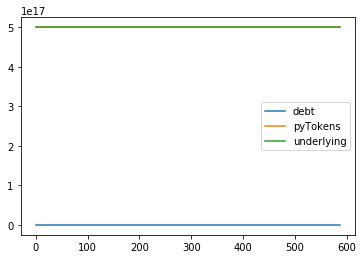

In [166]:
pandas.Series(debtOutstanding, name="debt").plot(legend=True)
pandas.Series(tSupply, name="pyTokens").plot(legend=True)
pandas.Series(ulying, name="underlying").plot(legend=True)

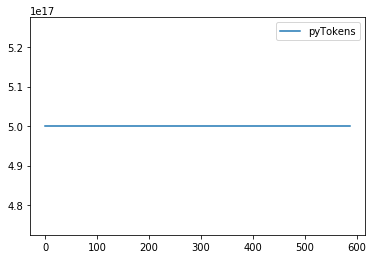

In [167]:
pandas.Series(tSupply, name="pyTokens").plot(legend=True)

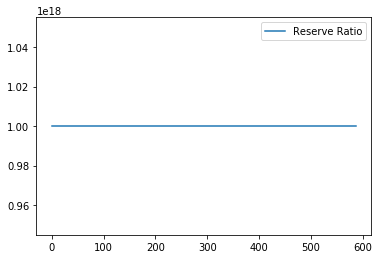

In [168]:
pandas.Series(qxA, name="Reserve Ratio").plot(legend=True)

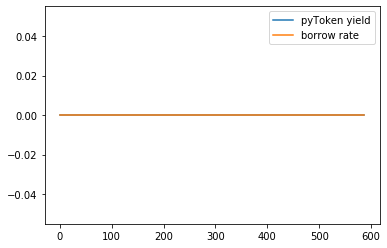

In [169]:
pandas.Series(pyratesA, name="pyToken yield").plot(legend=True)
pandas.Series(debtratesA,name="borrow rate").plot(legend=True)